In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Sun Aug 27 17:33:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [4]:
n_mels = 1024
n_outputs = 61
n_frames = 400

### Model

In [5]:
from model.model_conditional_transformer_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, h_dim=512, out_dim=n_outputs, n_layers=12)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [6]:
save_dir = '/data/scpark/save/lips/train08.27-2/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 130000, model, None, optimizer)

total 0


### Dataset

In [7]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [8]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [9]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


In [10]:
from torchaudio.transforms import Resample
resample = Resample(24000, 16000).to(device)

def get_states(wav, size, layer=16):
    # 24k to 16k
    wav = resample(wav)
    # Get probs.
    with torch.no_grad():
        states = wav2vec(wav, output_hidden_states=True).hidden_states[layer].transpose(1, 2)
    # Resizing
    states = F.interpolate(states, size=size, mode='linear').detach()
    return states


test : 0 1.0412307977676392
test : 1 1.0362166166305542
test : 2 1.0375126600265503
test : 3 1.0377709865570068
test : 4 1.0411113500595093
test : 5 1.0414713621139526
test : 6 1.0361465215682983
test : 7 1.0401897430419922
test : 8 1.0358723402023315
test : 9 1.0408790111541748
test_loss : 1.0388401746749878


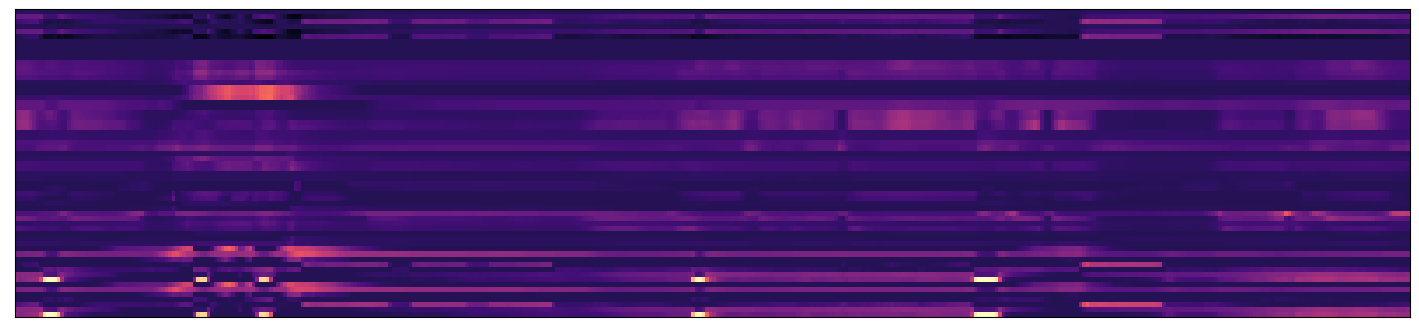

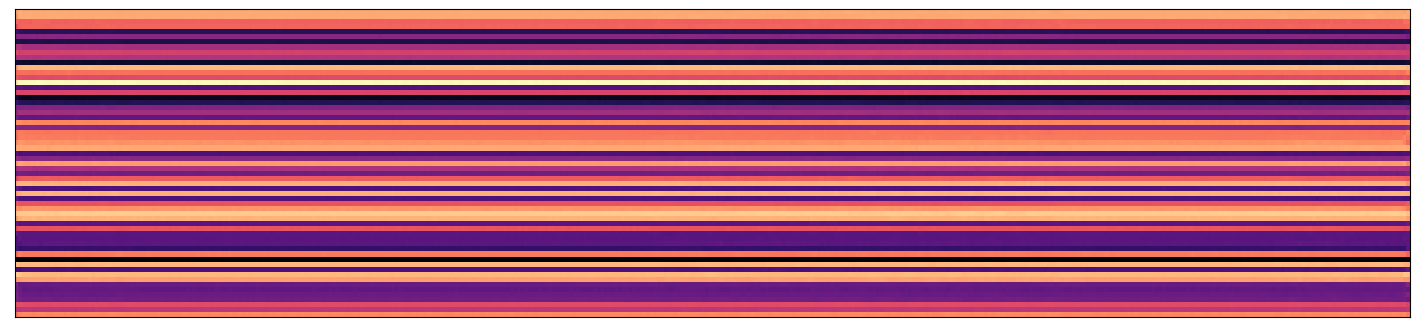

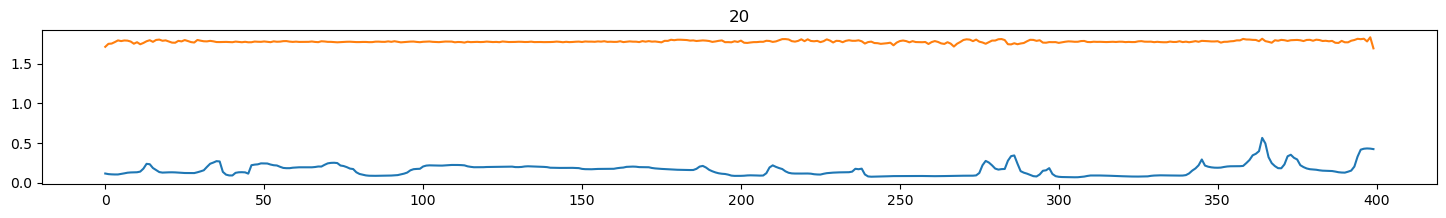

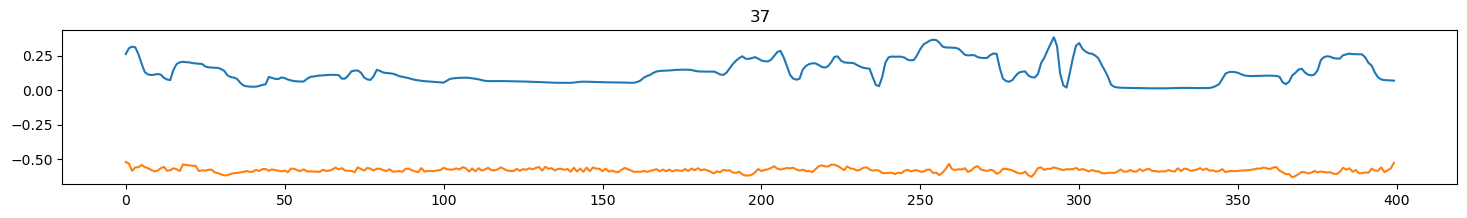

saved /data/scpark/save/lips/train08.27-2/save_0
1
loss 1.0147054195404053
1 1.0147054195404053
2
loss 0.628933846950531
2 0.628933846950531
3
loss 0.4145849645137787
3 0.4145849645137787
4
loss 0.27848079800605774
4 0.27848079800605774
5
loss 0.22339439392089844
5 0.22339439392089844
6
loss 0.1899985522031784
6 0.1899985522031784
7
loss 0.18409009277820587
7 0.18409009277820587
8
loss 0.17100514471530914
8 0.17100514471530914
9
loss 0.16679200530052185
9 0.16679200530052185
10
loss 0.15359267592430115
10 0.15359267592430115
11
loss 0.14683982729911804
11 0.14683982729911804
12
loss 0.1422300785779953
12 0.1422300785779953
13
loss 0.1376267671585083
13 0.1376267671585083
14
loss 0.13589905202388763
14 0.13589905202388763
15
loss 0.1311926543712616
15 0.1311926543712616
16
loss 0.1347624808549881
16 0.1347624808549881
17
loss 0.12842115759849548
17 0.12842115759849548
18
loss 0.12895531952381134
18 0.12895531952381134
19
loss 0.12676872313022614
19 0.12676872313022614
20
loss 0.12158010

160
loss 0.0910210981965065
160 0.0910210981965065
161
loss 0.08582239598035812
161 0.08582239598035812
162
loss 0.0880851000547409
162 0.0880851000547409
163
loss 0.08838581293821335
163 0.08838581293821335
164
loss 0.08717725425958633
164 0.08717725425958633
165
loss 0.08819881081581116
165 0.08819881081581116
166
loss 0.08525913208723068
166 0.08525913208723068
167
loss 0.08888303488492966
167 0.08888303488492966
168
loss 0.0825524628162384
168 0.0825524628162384
169
loss 0.08898036926984787
169 0.08898036926984787
170
loss 0.08959946781396866
170 0.08959946781396866
171
loss 0.0900261178612709
171 0.0900261178612709
172
loss 0.08565397560596466
172 0.08565397560596466
173
loss 0.08252357691526413
173 0.08252357691526413
174
loss 0.08417900651693344
174 0.08417900651693344
175
loss 0.08736409991979599
175 0.08736409991979599
176
loss 0.08949793130159378
176 0.08949793130159378
177
loss 0.0868232324719429
177 0.0868232324719429
178
loss 0.08735978603363037
178 0.08735978603363037
179

316
loss 0.08171569555997849
316 0.08171569555997849
317
loss 0.07353665679693222
317 0.07353665679693222
318
loss 0.07909291237592697
318 0.07909291237592697
319
loss 0.07363416999578476
319 0.07363416999578476
320
loss 0.07574544101953506
320 0.07574544101953506
321
loss 0.07576075941324234
321 0.07576075941324234
322
loss 0.07961813360452652
322 0.07961813360452652
323
loss 0.07506104558706284
323 0.07506104558706284
324
loss 0.07750196754932404
324 0.07750196754932404
325
loss 0.0740370973944664
325 0.0740370973944664
326
loss 0.07706580311059952
326 0.07706580311059952
327
loss 0.07602701336145401
327 0.07602701336145401
328
loss 0.07433223724365234
328 0.07433223724365234
329
loss 0.07340724021196365
329 0.07340724021196365
330
loss 0.07162207365036011
330 0.07162207365036011
331
loss 0.07468724250793457
331 0.07468724250793457
332
loss 0.0737878829240799
332 0.0737878829240799
333
loss 0.07485257834196091
333 0.07485257834196091
334
loss 0.07647141069173813
334 0.076471410691738

471 0.06926307827234268
472
loss 0.06497078388929367
472 0.06497078388929367
473
loss 0.06518053263425827
473 0.06518053263425827
474
loss 0.06782618910074234
474 0.06782618910074234
475
loss 0.07081235945224762
475 0.07081235945224762
476
loss 0.06930578500032425
476 0.06930578500032425
477
loss 0.06736302375793457
477 0.06736302375793457
478
loss 0.06756915152072906
478 0.06756915152072906
479
loss 0.06745844334363937
479 0.06745844334363937
480
loss 0.06888581067323685
480 0.06888581067323685
481
loss 0.06433523446321487
481 0.06433523446321487
482
loss 0.06722971796989441
482 0.06722971796989441
483
loss 0.06685122102499008
483 0.06685122102499008
484
loss 0.06633288413286209
484 0.06633288413286209
485
loss 0.06765282154083252
485 0.06765282154083252
486
loss 0.06942443549633026
486 0.06942443549633026
487
loss 0.059525515884160995
487 0.059525515884160995
488
loss 0.06634081900119781
488 0.06634081900119781
489
loss 0.06760028004646301
489 0.06760028004646301
490
loss 0.072749078

627
loss 0.06254066526889801
627 0.06254066526889801
628
loss 0.06635581701993942
628 0.06635581701993942
629
loss 0.05995325371623039
629 0.05995325371623039
630
loss 0.06212874501943588
630 0.06212874501943588
631
loss 0.06043326109647751
631 0.06043326109647751
632
loss 0.06047353893518448
632 0.06047353893518448
633
loss 0.06125703081488609
633 0.06125703081488609
634
loss 0.062144383788108826
634 0.062144383788108826
635
loss 0.06096817925572395
635 0.06096817925572395
636
loss 0.06557225435972214
636 0.06557225435972214
637
loss 0.06464643031358719
637 0.06464643031358719
638
loss 0.0645955353975296
638 0.0645955353975296
639
loss 0.06386271864175797
639 0.06386271864175797
640
loss 0.05976708233356476
640 0.05976708233356476
641
loss 0.057102132588624954
641 0.057102132588624954
642
loss 0.056504346430301666
642 0.056504346430301666
643
loss 0.06359944492578506
643 0.06359944492578506
644
loss 0.06304363161325455
644 0.06304363161325455
645
loss 0.0656496211886406
645 0.06564962

781 0.06296437978744507
782
loss 0.059934183955192566
782 0.059934183955192566
783
loss 0.059418294578790665
783 0.059418294578790665
784
loss 0.06045066565275192
784 0.06045066565275192
785
loss 0.06279802322387695
785 0.06279802322387695
786
loss 0.05926082283258438
786 0.05926082283258438
787
loss 0.06288760155439377
787 0.06288760155439377
788
loss 0.054752595722675323
788 0.054752595722675323
789
loss 0.05852137506008148
789 0.05852137506008148
790
loss 0.06526406109333038
790 0.06526406109333038
791
loss 0.057975154370069504
791 0.057975154370069504
792
loss 0.061956826597452164
792 0.061956826597452164
793
loss 0.06223040446639061
793 0.06223040446639061
794
loss 0.059239618480205536
794 0.059239618480205536
795
loss 0.06320680677890778
795 0.06320680677890778
796
loss 0.06030645594000816
796 0.06030645594000816
797
loss 0.05961063504219055
797 0.05961063504219055
798
loss 0.06242142617702484
798 0.06242142617702484
799
loss 0.05694673955440521
799 0.05694673955440521
800
loss 0

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(outputs['y_pred'][0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(outputs['y_pred'][0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)